In [18]:
def plot_umap_diff_mice(components, mice_sessions, num_hdc, num_nonhdc, plot_3d=False, title=None):
    num_neurons_per_mice = []
    for mouse_id in mice_sessions.keys():
        num = 0
        for session_id in mice_sessions[mouse_id]:
            num += num_hdc[mouse_id][session_id] + num_nonhdc[mouse_id][session_id]
        num_neurons_per_mice.append(num)

    cum_neurons = np.cumsum(np.array(num_neurons_per_mice))
    cum_neurons = np.insert(cum_neurons, 0, 0)

    # define the colormap
    colors = list(matplotlib.colors.BASE_COLORS)

    fig, ax = plt.subplots()
    for i, mouse_id in enumerate(mice_sessions.keys()):
            ax.scatter(components[cum_neurons[i]:cum_neurons[i+1], 0], components[cum_neurons[i]:cum_neurons[i+1], 1], c=colors[i], label=mouse_id, alpha=0.4)
    if title is None:
        ax.set_title('UMAP projection')
    else:
        ax.set_title(title)
    ax.legend()
    ax.grid()
    
    if plot_3d:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        for i, mouse_id in enumerate(mice_sessions.keys()):
                ax.scatter(components[cum_neurons[i]:cum_neurons[i+1], 0], components[cum_neurons[i]:cum_neurons[i+1], 1], components[cum_neurons[i]:cum_neurons[i+1], 2], c=colors[i], label=mouse_id, alpha=0.4)
        if title is None:
            ax.set_title('UMAP projection')
        else:
            ax.set_title(title)        
        ax.legend()

In [21]:
def plot_umap_hdc_nonhdc(components, filter_hdc, plot_3d=False, title=None):
    fig, ax = plt.subplots()
    ax.scatter(components[filter_hdc, 0], components[filter_hdc, 1], alpha=0.4, c='r', label='hd neurons')
    ax.scatter(components[np.invert(filter_hdc), 0], components[np.invert(filter_hdc), 1], alpha=0.4, c='b', label='non-hd neurons')
    if title is None:
        ax.set_title('UMAP projection')
    else:
        ax.set_title(title)   
    ax.legend()
    ax.grid()
    
    if plot_3d:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(components[filter_hdc, 0], components[filter_hdc, 1], components[filter_hdc, 2], 
                   alpha=0.4, c='r', label='hd neurons')
        ax.scatter(components[np.invert(filter_hdc), 0], components[np.invert(filter_hdc), 1], components[np.invert(filter_hdc), 2], 
                   alpha=0.4, c='b', label='non-hd neurons')
        if title is None:
            ax.set_title('UMAP projection')
        else:
            ax.set_title(title)
        ax.legend()

# Dimensionality reduction on tuning curves with entire spike count probability distributions

In [1]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import pickle


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib


# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.12.1+cu102
Using device: cuda:0


In [8]:
def load_scd_data(datadir, mouse_id, session_id, subset, phase='wake'):
    data = np.load(datadir + f'{mouse_id}_{session_id}_{phase}_{subset}.npz')
    scds = data['scd']  # (neurons, num_cov, steps)
    cov = data['covariates']  # (num_cov, steps)
    
    return scds, cov

In [86]:
datadir = '/scratches/ramanujan_2/vn283/HDC_PartIII/scd_data/'

phase='wake'

mice_sessions = {
    'Mouse12': ['120806'],#, '120807'],
    'Mouse17': ['130125', '130128', '130131', '130202', '130203'],
    'Mouse20': ['130514', '130515', '130516', '130517'],
    'Mouse24': ['131213', '131217', '131218'],
    'Mouse25': ['140124', '140128', '140129'],
    'Mouse28': ['140310']
} 

# find shape of data
mouse_id = 'Mouse12'
session_id = '120806'
subset='hdc'
data, _ = load_scd_data(datadir, mouse_id, session_id, subset)  # (neurons, num_cov, steps)
count = data.shape[2]
steps = data.shape[1]
num_neurons = data.shape[0]

num_hdc = {}
num_nonhdc = {}
features = np.empty((0, steps, count))  # we have 6 covariates, so 6 features
for mouse_id in mice_sessions.keys():
    num_hdc[mouse_id] = {}
    num_nonhdc[mouse_id] = {}
    for session_id in mice_sessions[mouse_id]:
        for subset in ['hdc', 'nonhdc']:
            scds, covariates = load_scd_data(datadir, mouse_id, session_id, subset)

            if subset == 'hdc':
                num_hdc[mouse_id][session_id] = scds.shape[0]
            else:
                num_nonhdc[mouse_id][session_id] = scds.shape[0]
            
            # need to pad the distributions with 0 since they don't have the same max spike count
            diff = np.abs(features.shape[2] - scds.shape[2])
            if features.shape[2] < scds.shape[2]:
                features = np.pad(features, ((0,0),(0,0),(0,diff)), mode='constant', constant_values=0)
            else:
                scds = np.pad(scds, ((0,0),(0,0),(0,diff)), mode='constant', constant_values=0)
            features = np.concatenate((features, scds), axis=0)

print(features.shape)

labels_hdc = []

for mouse_id in mice_sessions.keys():
    for session_id in mice_sessions[mouse_id]:
        labels_hdc += [1]*num_hdc[mouse_id][session_id] + [0]*num_nonhdc[mouse_id][session_id]

labels_mice = []

for i, mouse_id in enumerate(mice_sessions.keys()):
    for session_id in mice_sessions[mouse_id]:
        labels_mice += [i]*(num_hdc[mouse_id][session_id] + num_nonhdc[mouse_id][session_id])
        
filter_hdc = np.array(labels_hdc).astype(bool)

K = features.shape[2]
steps = features.shape[1]
neurons = features.shape[0]

features = np.reshape(features, (neurons, steps*K))

(647, 100, 120)


## Define custom metric for umap

In [82]:
import numba

@numba.njit()
def hellinger(x, y):
    result = 0.0
    l1_norm_x = 0.0
    l1_norm_y = 0.0

    for i in range(x.shape[0]):
        result += np.sqrt(x[i] * y[i])
        l1_norm_x += x[i]
        l1_norm_y += y[i]
        
    else:
        return np.sqrt(1 - result / np.sqrt(l1_norm_x * l1_norm_y))

In [83]:
@numba.njit()
def correlation_hellinger(x, y, steps, K):
    x = np.reshape(x, (steps, K))
    y = np.reshape(y, (steps, K))
    result = 0
    for i in range(x.shape[0]):
        result += hellinger(x[i], y[i])
    
    return result

In [68]:
x = features[0]
y = features[1]
print(x.shape)

print(correlation_hellinger(x, y, steps, K))

(12000,)
5.3023589137517035


(647, 3)


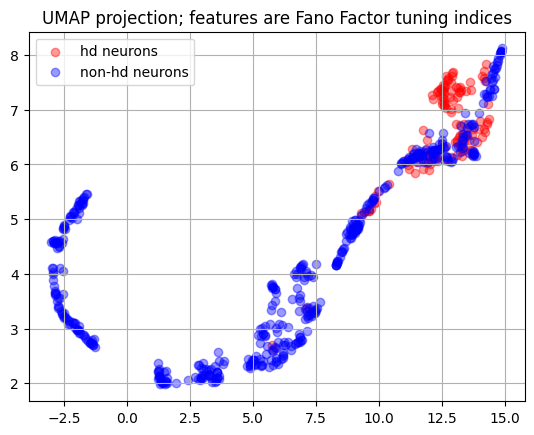

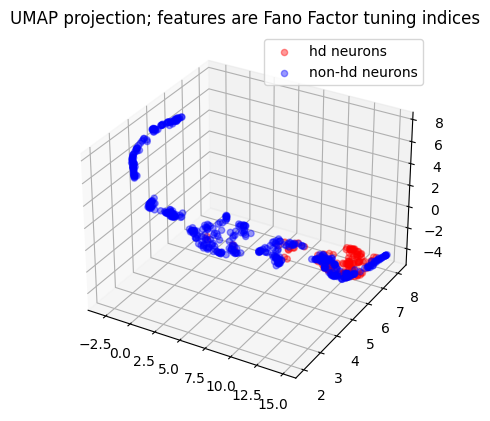

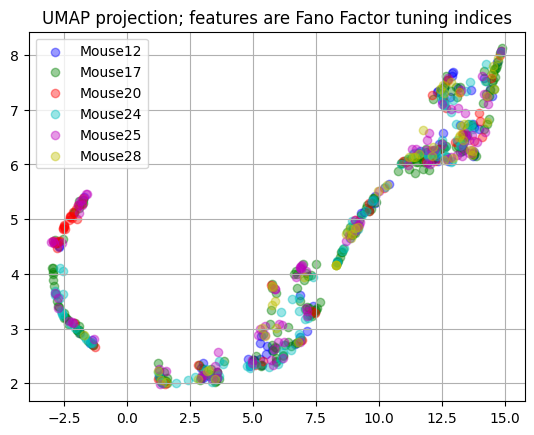

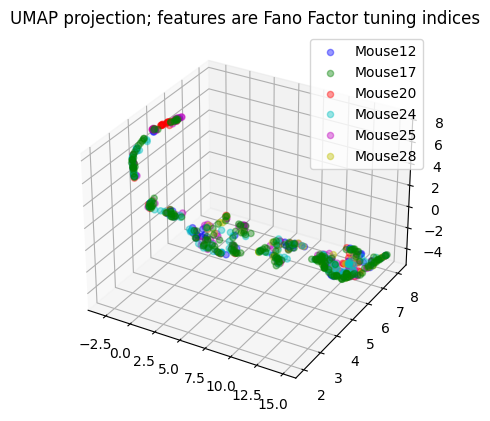

In [95]:
import umap

kwds = [steps, K]
mapping = umap.UMAP(n_neighbors=30, min_dist=0.05, n_components=3, metric=correlation_hellinger, metric_kwds={'steps':steps, 'K':K}).fit(features)
embedding = mapping.embedding_
print(embedding.shape)
plot_umap_hdc_nonhdc(embedding, filter_hdc, title='UMAP projection; features are Fano Factor tuning indices', plot_3d=True)
plot_umap_diff_mice(embedding, mice_sessions, num_hdc, num_nonhdc, title='UMAP projection; features are Fano Factor tuning indices', plot_3d=True)